# Integrating scRNA and protein in bone marrow cells

Given two single-cell datasets profiled with different modalities scConfluence can map each in low-dimensional latent space shared by both modalities where distances between cell embeddings depends only on their biological similarity. We show here an example of integration on a bone marrow dataset where gene expression and protein abundance were measured.

## Imports

Of note, `scikit-misc` as well as `louvain` should be installed (can be done with pip) for this notebook to be executed.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.spatial.distance import cdist
import muon as mu
import numpy as np
import anndata as ad
import scanpy as sc
import torch
torch.manual_seed(1792)

import scconfluence

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

You can download the unpaired multimodal demo dataset for this tutorial from https://figshare.com/s/f2623d650c3b93cb1d6f.

In [2]:
mdata = mu.read_h5mu("RNA_PROT_demo.h5mu.gz")
mdata

MuData object with n_obs × n_vars = 8000 × 14087
  obs:	'celltype', 'batch', 'modality'
  var:	'feature_types', 'gene_id'
  2 modalities
    rna:	4000 x 13953
      obs:	'batch', 'celltype'
    adt:	4000 x 134
      obs:	'batch', 'celltype'
      var:	'gene_connection'

## Perform basic quality control

We can use scanpy functions to filter out cells or features with low quality measurements, more advanced quality control could be appropriate depending on the technologies used to obtain the data.

In [3]:
sc.pp.filter_cells(mdata["rna"], min_genes=100)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["adt"], min_genes=10)
# we're actually filtering proteins here
sc.pp.filter_genes(mdata["adt"], min_cells=20)
mdata.update()
mdata

MuData object with n_obs × n_vars = 8000 × 13865
  obs:	'celltype', 'batch', 'modality'
  var:	'n_cells', 'feature_types', 'gene_id'
  2 modalities
    rna:	4000 x 13731
      obs:	'batch', 'celltype', 'n_genes'
      var:	'n_cells'
    adt:	4000 x 134
      obs:	'batch', 'celltype', 'n_genes'
      var:	'gene_connection', 'n_cells'

## Preprocess common features and obtain cross-modality distance matrix

Diagonal integration, i.e. single cell multimodal unpaired integration, is a very challenging task as it aims at aligning cells in which different features were measured. To guide the alignment, we need to leverage prior biological knowledge to obtain a set of common features across modalities which will serve as a bridge for the integration. For RNA-Protein integration, those common features are derived from the matching of proteins with their coding genes. Once those common feature representations have been obtained, we can derive a distance matrix whose rows correspond to cells in the RNA modality and columns correspond to the cells in the ADT modality which will be used by scConfluence.

In [4]:
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["adt"].var["gene_connection"].values))
cm_features_rna = mdata["rna"][:, cm_genes].copy() 
prot_genes_idx = [list(mdata["adt"].var["gene_connection"].values).index(g) for g in cm_genes]
cm_features_adt = mdata["adt"][:, prot_genes_idx].copy()

In [5]:
sc.pp.normalize_total(cm_features_rna, target_sum=10000.)
sc.pp.log1p(cm_features_rna)

mu.prot.pp.clr(cm_features_adt, axis=1)

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [6]:
mdata.uns["cross_rna+adt"] = cdist(np.array(cm_features_rna.X.todense()), np.array(cm_features_adt.X.todense()))
mdata.uns["cross_keys"] = ["cross_rna+adt"]

## Preprocess each modality

While the computation of the distance matrix only involved features that were connected across modalities (proteins and their corresponding coding genes), our method leverages all original features to perform dimension reductions. 

In [7]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts it makes sense to select highly variable genes based on both
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False, 
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False, 
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()
sc.tl.pca(mdata["rna"], n_comps=100, zero_center=None)

In [8]:
mu.prot.pp.clr(mdata["adt"], axis=1)

## Define autoencoders for each modality

We define one autoencoder per modality whose aim is to extract all the biological information present in the original features while accounting for batch effects (not present here since there's only one batch) and projecting the cells to a shared latent space of low dimension (hence the dimension of the latent space `n_latent` should be the same for all autoencoders). Multiple options can be set to adapt the autoencoders to the specificity of the modalities measured, see the API documentation for details about the arguments. 

In [9]:
autoencoders = {"rna": scconfluence.unimodal.AutoEncoder(mdata["rna"], 
                                                         modality="rna", 
                                                         rep_in="X_pca", 
                                                         rep_out="counts", 
                                                         batch_key="batch",
                                                         n_hidden=64, 
                                                         n_latent=16,
                                                         type_loss="zinb"),
                "adt": scconfluence.unimodal.AutoEncoder(mdata["adt"], 
                                                         modality="adt", 
                                                         rep_in=None, 
                                                         rep_out=None, 
                                                         batch_key="batch",
                                                         n_hidden=32,#lower than default as there are less features
                                                         n_latent=16,
                                                         type_loss="l2")}

## Create and train the model

The scConfluence model leverages the distance matrix stored in `mdata` to align the latent embeddings learned by autoencoders from each modality. We used here the default parameters, see the API's documention for details on their meaning. While the maximum over of epochs is set to 1000, we use earlystopping to interrupt the training when the loss has converged on validation samples which generally happens long before the upper limit of 1000 epochs. With a GPU, this training is expected to take less than 5 minutes.

In [10]:
%%time
model = scconfluence.model.ScConfluence(mdata=mdata, unimodal_aes=autoencoders, 
                                        mass=0.5, reach=0.3, iot_loss_weight=0.01, sinkhorn_loss_weight=0.1)
model.fit(save_path="demo_rna_adt", use_cuda=True, max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /pasteur/appa/homes/jsamaran/scConfluence/demo_rna_adt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | aes  | ModuleDict | 884 K 
------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Tot

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█████████████████████████| 13/13 [00:00<00:00, 21.46it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████| 13/13 [00:00<00:00, 26.73it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████| 13/13 [00:00<00:00, 27.33it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████| 13/13 [00:00<00:00, 26.83it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████| 13/13 [00:00<00:00, 27.00it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████| 13/13 [00:00<00:00, 27.24it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|████████████████████████| 13/13 [00:00<00:00, 26.68it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|████████████████████████| 13/13 [00:00<00:00, 26.82it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████| 13/13 [00:00<00:00, 26.90it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|████████████████████████| 13/13 [00:00<00:00, 26.61it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|████████████████████████| 13/13 [00:00<00:00, 27.09it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|████████████████████████| 13/13 [00:00<00:00, 27.57it/s, v_num=8]
Validation: |               

Epoch 25: 100%|████████████████████████| 13/13 [00:00<00:00, 27.66it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|████████████████████████| 13/13 [00:00<00:00, 26.58it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|████████████████████████| 13/13 [00:00<00:00, 26.48it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|████████████████████████| 13/13 [00:00<00:00, 27.17it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|████████████████████████| 13/13 [00:00<00:00, 26.81it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|████████████████████████| 13/13 [00:00<00:00, 27.54it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|█████████████

Epoch 37: 100%|████████████████████████| 13/13 [00:00<00:00, 27.49it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|████████████████████████| 13/13 [00:00<00:00, 26.46it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|████████████████████████| 13/13 [00:00<00:00, 28.19it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|████████████████████████| 13/13 [00:00<00:00, 28.01it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|████████████████████████| 13/13 [00:00<00:00, 26.79it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|████████████████████████| 13/13 [00:00<00:00, 26.72it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|█████████████

Epoch 49: 100%|████████████████████████| 13/13 [00:00<00:00, 27.48it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|████████████████████████| 13/13 [00:00<00:00, 26.84it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|████████████████████████| 13/13 [00:00<00:00, 28.14it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|████████████████████████| 13/13 [00:00<00:00, 27.63it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|████████████████████████| 13/13 [00:00<00:00, 27.33it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|████████████████████████| 13/13 [00:00<00:00, 27.85it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|█████████████

Epoch 61: 100%|████████████████████████| 13/13 [00:00<00:00, 26.92it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|████████████████████████| 13/13 [00:00<00:00, 27.68it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|████████████████████████| 13/13 [00:00<00:00, 28.20it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|████████████████████████| 13/13 [00:00<00:00, 27.81it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|████████████████████████| 13/13 [00:00<00:00, 27.37it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|████████████████████████| 13/13 [00:00<00:00, 27.15it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|█████████████

Epoch 73: 100%|████████████████████████| 13/13 [00:00<00:00, 27.98it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|████████████████████████| 13/13 [00:00<00:00, 27.82it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|████████████████████████| 13/13 [00:00<00:00, 27.78it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|████████████████████████| 13/13 [00:00<00:00, 27.69it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|████████████████████████| 13/13 [00:00<00:00, 27.76it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|████████████████████████| 13/13 [00:00<00:00, 28.15it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|█████████████

Epoch 85: 100%|████████████████████████| 13/13 [00:00<00:00, 27.01it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|████████████████████████| 13/13 [00:00<00:00, 27.63it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|████████████████████████| 13/13 [00:00<00:00, 27.25it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|████████████████████████| 13/13 [00:00<00:00, 27.07it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|████████████████████████| 13/13 [00:00<00:00, 27.33it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|████████████████████████| 13/13 [00:00<00:00, 27.79it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 91: 100%|█████████████

Epoch 97: 100%|████████████████████████| 13/13 [00:00<00:00, 27.29it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|████████████████████████| 13/13 [00:00<00:00, 18.98it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|████████████████████████| 13/13 [00:00<00:00, 27.42it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|███████████████████████| 13/13 [00:00<00:00, 27.47it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|███████████████████████| 13/13 [00:00<00:00, 28.01it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|███████████████████████| 13/13 [00:00<00:00, 27.69it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|████████████

Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 110: 100%|███████████████████████| 13/13 [00:00<00:00, 27.53it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|███████████████████████| 13/13 [00:00<00:00, 26.60it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|███████████████████████| 13/13 [00:00<00:00, 27.73it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|███████████████████████| 13/13 [00:00<00:00, 27.98it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|███████████████████████| 13/13 [00:00<00:00, 28.26it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|███████████████████████| 13/13 [00:00<00:00, 27.73it/s, v_num=8]
Validation: |               

Epoch 122: 100%|███████████████████████| 13/13 [00:00<00:00, 27.18it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 123: 100%|███████████████████████| 13/13 [00:00<00:00, 27.71it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 124: 100%|███████████████████████| 13/13 [00:00<00:00, 27.09it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 125: 100%|███████████████████████| 13/13 [00:00<00:00, 28.09it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 126: 100%|███████████████████████| 13/13 [00:00<00:00, 27.26it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 127: 100%|███████████████████████| 13/13 [00:00<00:00, 27.72it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 128: 100%|████████████

Epoch 134: 100%|███████████████████████| 13/13 [00:00<00:00, 26.94it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 135: 100%|███████████████████████| 13/13 [00:00<00:00, 27.70it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 136: 100%|███████████████████████| 13/13 [00:00<00:00, 27.41it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 137: 100%|███████████████████████| 13/13 [00:00<00:00, 27.57it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 138: 100%|███████████████████████| 13/13 [00:00<00:00, 27.56it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 139: 100%|███████████████████████| 13/13 [00:00<00:00, 27.65it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 140: 100%|████████████

Epoch 146: 100%|███████████████████████| 13/13 [00:00<00:00, 27.41it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 147: 100%|███████████████████████| 13/13 [00:00<00:00, 27.04it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 148: 100%|███████████████████████| 13/13 [00:00<00:00, 27.81it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|███████████████████████| 13/13 [00:00<00:00, 28.10it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 150: 100%|███████████████████████| 13/13 [00:00<00:00, 27.07it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 151: 100%|███████████████████████| 13/13 [00:00<00:00, 28.19it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 152: 100%|████████████

Epoch 158: 100%|███████████████████████| 13/13 [00:00<00:00, 27.62it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 159: 100%|███████████████████████| 13/13 [00:00<00:00, 28.00it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|███████████████████████| 13/13 [00:00<00:00, 27.89it/s, v_num=8]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|███████████████████████| 13/13 [00:00<00:00, 21.55it/s, v_num=8]
CPU times: user 1min 30s, sys: 2.15 s, total: 1min 32s
Wall time: 1min 44s


## Obtaining and visualizing latent embeddings of all cells

In [11]:
mdata.obsm["latent"] = model.get_latent(use_cuda=True).loc[mdata.obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 80.52it/s]


While conclusions should not be drawn from UMAP plots we use it here to visualize the results of the integration.

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


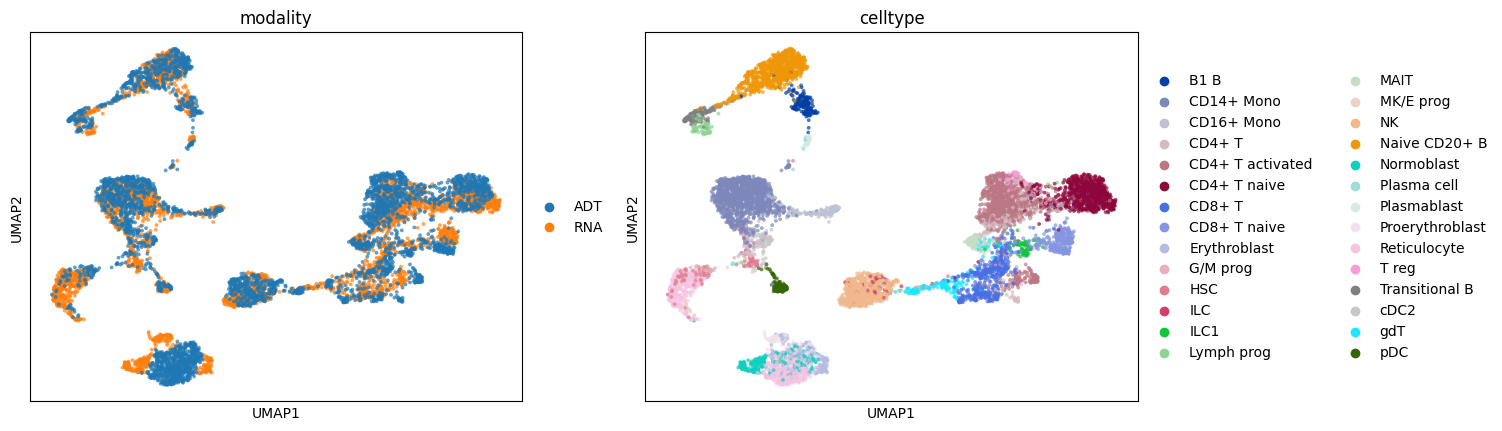

In [12]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=30, alpha=0.7)

## Clustering the latent embeddings

Since the data was collected from multiple experimental batches, we can also check that they don't form separated clusters in the learned latent space.

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


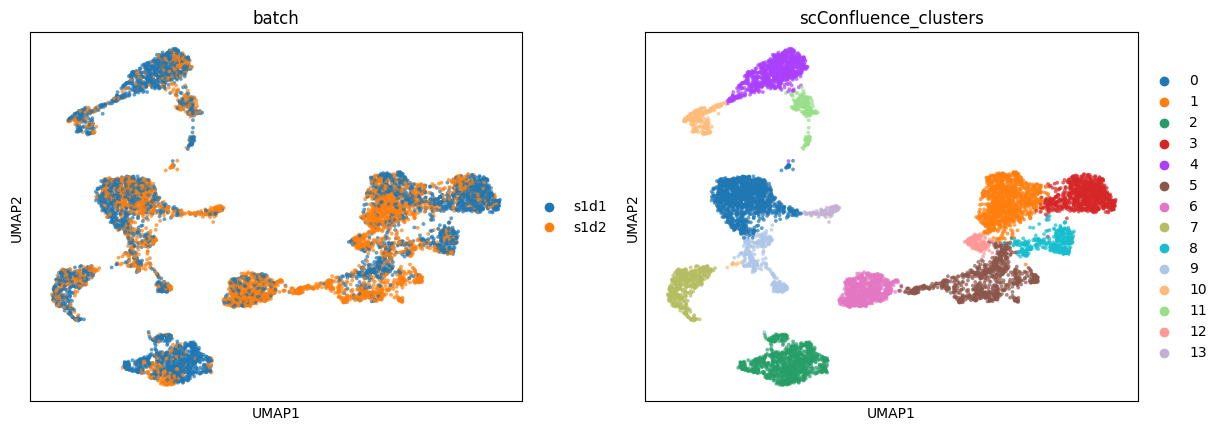

In [13]:
sc.tl.louvain(mdata, resolution=.5, neighbors_key='scConfluence', key_added='scConfluence_clusters')
sc.pl.umap(mdata, color=['batch', 'scConfluence_clusters'], size=30, alpha=0.7)